<a href="https://colab.research.google.com/github/davra98/davra98/blob/main/Codice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Progetto di Advanced Machine Learning
In questo notebook vi è il codice del progetto di Advanced Machine Learning.

Il gruppo che ha lavorato al progetto è composto da:


*   Manella Kevin (829549)
*   Ratto Davide (827130)
*   Talamona Stefano (822452)


In questo notebook il codice sarà commentato a grandi linee, per una descrizione più approfondita del progetto si consiglia di guardare il report.

### Import

In [ ]:
!pip install tensorflow-addons
!pip install -q -U keras-tuner

import os
import cv2
import numpy
import matplotlib.pyplot
import tensorflow

from google.colab import drive
from sklearn.utils import shuffle
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tensorflow_addons.image import rotate
from keras_tuner import RandomSearch
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from glob import glob
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

## Drive

In [ ]:
drive.mount('/content/gdrive', force_remount = True)

Mounted at /content/gdrive


## 1) CNN e Data Augmentation

### Caricamento del dataset

In [ ]:
# Funzione per il caricamento del dataset
def get_images(directory):
  images = []
  labels = []

  # Caricamento label
  for lbl in os.listdir(directory):
    if lbl == 'new_angry':
      label = 0
    elif lbl == 'new_disgust':
      label = 1
    elif lbl == 'new_fear':
      label = 2
    elif lbl == 'new_happy':
      label = 3
    elif lbl == 'new_neutral':
      label = 4
    elif lbl == 'new_sad':
      label = 5
    elif lbl == 'new_surprise':
      label = 6

    for image_file in os.listdir(directory + lbl):
      # Caricamento immagini
      image = cv2.imread(directory + lbl + r'/' + image_file, cv2.IMREAD_GRAYSCALE)
      images.append(image)
      labels.append(label)

  return (images, labels)

In [ ]:
# Training set
train_images, train_labels = get_images('/content/gdrive/MyDrive/ProgettoAML/data/new_train/')
train_images, train_labels = shuffle(train_images, train_labels, random_state = 42)

# Test set
test_images, test_labels = get_images('/content/gdrive/MyDrive/ProgettoAML/data/new_test/')

train_images = numpy.array(train_images)
test_images = numpy.array(test_images)

# Normalizzazione dei dati tra 0 e 1
train_images = train_images / 255.0
test_images = test_images / 255.0

# Conversione da label intere a one-hot-vector
classes_number = 7
train_labels = keras.utils.to_categorical(train_labels, classes_number)
test_labels = keras.utils.to_categorical(test_labels, classes_number)

print('train_images.shape:', train_images.shape)
print('train_labels.shape:', train_labels.shape)

print('test_images.shape:', test_images.shape)
print('test_labels.shape:', test_labels.shape)
print('--------------------------------------------------')

# Validation set
train_images, validation_images, train_labels, validation_labels = train_test_split(train_images, train_labels, test_size = 0.1, random_state = 42)

print('train_images.shape:', train_images.shape)
print('train_labels.shape:', train_labels.shape)

print('validation_images.shape:', validation_images.shape)
print('validation_labels.shape:', validation_labels.shape)

train_images.shape: (2800, 48, 48)
train_labels.shape: (2800, 7)
test_images.shape: (700, 48, 48)
test_labels.shape: (700, 7)
--------------------------------------------------
train_images.shape: (2520, 48, 48)
train_labels.shape: (2520, 7)
validation_images.shape: (280, 48, 48)
validation_labels.shape: (280, 7)


### Data Augmentation

In [ ]:
# Funzione per la stampa delle immagini
def visualize(original, augmented):
  fig = matplotlib.pyplot.figure()

  # Immagine originale
  matplotlib.pyplot.subplot(1, 2, 1)
  matplotlib.pyplot.title('Immagine originale')
  matplotlib.pyplot.imshow(original[:, :, 0], cmap = 'gray', vmin = 0, vmax = 1)
  matplotlib.pyplot.axis('off')

  # Immagine modificata
  matplotlib.pyplot.subplot(1, 2, 2)
  matplotlib.pyplot.title('Immagine modificata')
  matplotlib.pyplot.imshow(augmented[:, :, 0], cmap = 'gray', vmin = 0, vmax = 1)
  matplotlib.pyplot.axis('off')

In [ ]:
train_images = train_images.reshape(train_images.shape[0], 48, 48, 1)
validation_images = validation_images.reshape(validation_images.shape[0], 48, 48, 1)
test_images = test_images.reshape(test_images.shape[0], 48, 48, 1)

# Immagini capovolte sinistra/destra
flipped_images = tensorflow.image.flip_left_right(train_images)

# Immagini con luminosità diversa
brighted_images = tensorflow.image.random_brightness(train_images, 0.4)

# Immagini con aggiunta di rumore random
noised_images = train_images + numpy.random.normal(0, 0.05, train_images.shape)

# Immagini con contrasto diverso
contrasted_images = tensorflow.image.stateless_random_contrast(train_images, 0, 5, seed = [1, 3])

# Immagini ruotate a sinistra e a destra
angle = 10.0 * numpy.pi / 180.0
left_rotated_images = rotate(train_images, angle, interpolation = 'bilinear')
right_rotated_images = rotate(train_images, - angle, interpolation = 'bilinear')

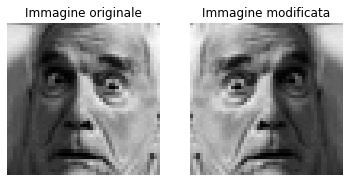

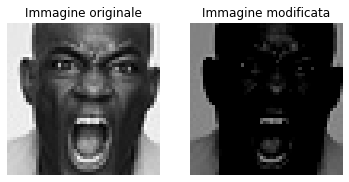

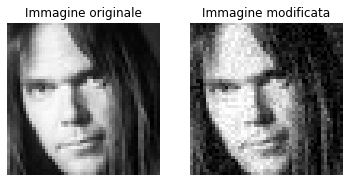

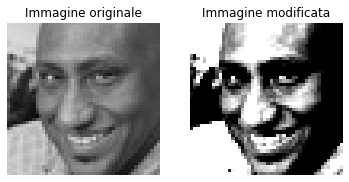

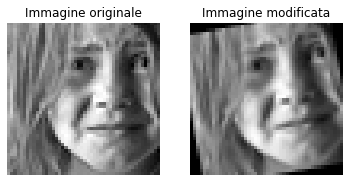

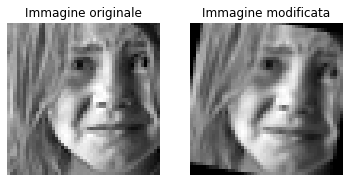

In [ ]:
# Visualizzazione di alcune immagini originali con le rispettive versioni modificate
visualize(train_images[10], flipped_images[10])
visualize(train_images[209], brighted_images[209])
visualize(train_images[666], noised_images[666])
visualize(train_images[2000], contrasted_images[2000])
visualize(train_images[55], left_rotated_images[55])
visualize(train_images[55], right_rotated_images[55])

In [ ]:
# Training set aumentato
augmented_train_images = numpy.vstack([train_images, flipped_images])
augmented_train_images = numpy.vstack([augmented_train_images, brighted_images])
augmented_train_images = numpy.vstack([augmented_train_images, noised_images])
augmented_train_images = numpy.vstack([augmented_train_images, contrasted_images])
augmented_train_images = numpy.vstack([augmented_train_images, left_rotated_images])
augmented_train_images = numpy.vstack([augmented_train_images, right_rotated_images])

augmented_train_labels = numpy.tile(train_labels, (classes_number, 1))

augmented_train_images, augmented_train_labels = shuffle(augmented_train_images, augmented_train_labels, random_state = 42)

print('augmented_train_images.shape:', augmented_train_images.shape)
print('augmented_train_labels.shape:', augmented_train_labels.shape)

augmented_train_images.shape: (17640, 48, 48, 1)
augmented_train_labels.shape: (17640, 7)


### Funzioni di supporto

In [ ]:
# Funzione per la creazione del modello
def build_model(hp):
  # Creazione del modello
  model = keras.Sequential([
  # Primo layer convoluzionale
  keras.layers.Conv2D(
    filters = hp.Int('conv_1_filter', min_value = 16, max_value = 32, step = 8),
    kernel_size = hp.Choice('conv_1_kernel', values = [5]),
    activation = 'relu',
    input_shape = input_shape),
  # Layer di Max Pooling
  keras.layers.MaxPool2D(pool_size = (2, 2)),
  # Secondo layer convoluzionale
  keras.layers.Conv2D(
    filters = hp.Int('conv_2_filter', min_value = 16, max_value = 64, step = 16),
    kernel_size = hp.Choice('conv_2_kernel', values = [3]),
    activation = 'relu'),
  # Layer di Max Pooling
  keras.layers.MaxPool2D(pool_size = (2, 2)),
  # Terzo layer convoluzionale
  keras.layers.Conv2D(
    filters = hp.Int('conv_3_filter', min_value = 32, max_value = 96, step = 16),
    kernel_size = hp.Choice('conv_3_kernel', values = [3]),
    activation = 'relu'),
  # Layer di Max Pooling
  keras.layers.MaxPool2D(pool_size = (2, 2)),
  # Layer di Dropout
  keras.layers.Dropout(rate = hp.Choice('rate1', values = [0.2, 0.5, 0.7])),
  # Quarto layer convoluzionale
  keras.layers.Conv2D(
    filters = hp.Int('conv_4_filter', min_value = 48, max_value = 112, step = 16),
    kernel_size = hp.Choice('conv_4_kernel', values = [3]),
    activation = 'relu'),
  # Layer di Dropout
  keras.layers.Dropout(rate = hp.Choice('rate2', values = [0.5, 0.8])),
  # Flatten Layer
  keras.layers.Flatten(),
  # Layer di Output
  keras.layers.Dense(classes_number, activation = 'softmax')])

  # Compilazione del modello
  model.compile(optimizer = keras.optimizers.Adam(hp.Choice('learning_rate', values = [0.001])),
                loss = 'categorical_crossentropy',
                metrics = ['accuracy'])

  return model

In [ ]:
# Funzione per fare i grafici su Loss e Accuracy
def plot_history(network_history):
  x_plot = list(range(1, epochs_number + 1))

  # Training Loss VS Validation Loss
  matplotlib.pyplot.figure()
  matplotlib.pyplot.xlabel('Epochs')
  matplotlib.pyplot.ylabel('Loss')
  matplotlib.pyplot.plot(x_plot, network_history.history['loss'])
  matplotlib.pyplot.plot(x_plot, network_history.history['val_loss'])
  matplotlib.pyplot.legend(['Training', 'Validation'])

  # Training Accuracy VS Validation Accuracy
  matplotlib.pyplot.figure()
  matplotlib.pyplot.xlabel('Epochs')
  matplotlib.pyplot.ylabel('Accuracy')
  matplotlib.pyplot.plot(x_plot, network_history.history['accuracy'])
  matplotlib.pyplot.plot(x_plot, network_history.history['val_accuracy'])
  matplotlib.pyplot.legend(['Training', 'Validation'], loc = 'lower right')

  matplotlib.pyplot.show()

### CNN su dataset iniziale con Auto Tuning

In [ ]:
input_shape = train_images[0].shape
epochs_number = 50
batch_size = 128

# Per l'Auto Tuning
tuner = RandomSearch(build_model,
                    objective = 'val_accuracy',
                    max_trials = 20)

# Ricerca dei parametri migliori
tuner.search(train_images, train_labels, epochs = epochs_number, batch_size = batch_size, validation_data = (validation_images, validation_labels))

In [ ]:
# Parametri migliori
best_parameters = tuner.get_best_hyperparameters(num_trials = 1)[0]

# Modello con parametri migliori
tuned_model = tuner.hypermodel.build(best_parameters)

# Allenamento modello e stampa grafici
history = tuned_model.fit(train_images, train_labels, epochs = epochs_number, batch_size = batch_size, validation_data = (validation_images, validation_labels))

Epoch 1/50
20/20 [==============================] - 1s 32ms/step - loss: 1.9514 - accuracy: 0.1405 - val_loss: 1.9458 - val_accuracy: 0.1429
Epoch 2/50
20/20 [==============================] - 0s 19ms/step - loss: 1.9469 - accuracy: 0.1401 - val_loss: 1.9457 - val_accuracy: 0.1179
Epoch 3/50
20/20 [==============================] - 0s 19ms/step - loss: 1.9447 - accuracy: 0.1433 - val_loss: 1.9416 - val_accuracy: 0.2143
Epoch 4/50
20/20 [==============================] - 0s 20ms/step - loss: 1.9336 - accuracy: 0.1774 - val_loss: 1.9127 - val_accuracy: 0.2464
Epoch 5/50
20/20 [==============================] - 0s 20ms/step - loss: 1.8897 - accuracy: 0.2123 - val_loss: 1.8255 - val_accuracy: 0.2679
Epoch 6/50
20/20 [==============================] - 0s 19ms/step - loss: 1.8242 - accuracy: 0.2472 - val_loss: 1.7699 - val_accuracy: 0.2607
Epoch 7/50
20/20 [==============================] - 0s 20ms/step - loss: 1.7858 - accuracy: 0.2694 - val_loss: 1.7192 - val_accuracy: 0.3214
Epoch 8/50
20

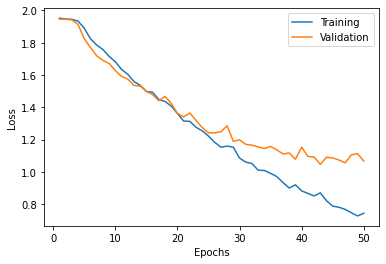

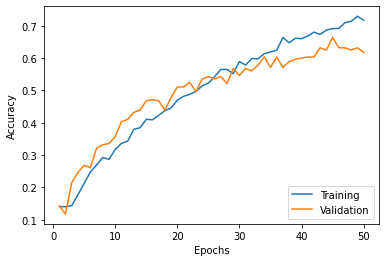

In [ ]:
plot_history(history)

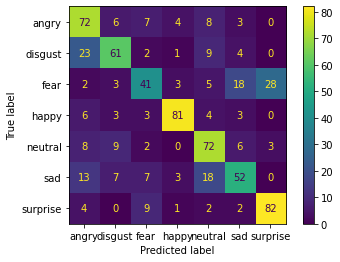

Score on test set: 65.86%


In [ ]:
# Codice per fare la matrice di confusione

classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

predictions = tuned_model.predict(test_images)
predictions = [numpy.argmax(predictions[i]) for i in range(len(predictions))]

test_labels_for_confusion_matrix = [numpy.argmax(test_labels[i]) for i in range(len(test_labels))]

confusionMatrix = confusion_matrix(y_true = test_labels_for_confusion_matrix, y_pred = predictions)
ConfusionMatrixDisplay(confusion_matrix = confusionMatrix, display_labels = classes).plot()
matplotlib.pyplot.show()

# Per far vedere che è uguale a quello calcolato nel prossimo blocco di codice
test_score = numpy.mean(numpy.diagonal(confusionMatrix / numpy.sum(confusionMatrix, axis = 1)))
print('%s: %.2f%%' % ('Score on test set', test_score * 100))

In [ ]:
test_score = tuned_model.evaluate(test_images, test_labels, verbose = 0)
print('%s: %.2f%%' % ('Score on test set', test_score[1] * 100))

Score on test set: 65.86%


### CNN su dataset aumentato con Auto Tuning

In [ ]:
# Rimozione dei file relativi all'Auto Tuning precedente
!rm untitled_project/oracle.json
!rm untitled_project/tuner0.json

input_shape = augmented_train_images[0].shape
epochs_number = 50
batch_size = 128

# Per l'Auto Tuning
tuner = RandomSearch(build_model,
                    objective = 'val_accuracy',
                    max_trials = 20)

# Ricerca dei parametri migliori
tuner.search(augmented_train_images, augmented_train_labels, epochs = epochs_number, batch_size = batch_size, validation_data = (validation_images, validation_labels))

In [ ]:
# Parametri migliori
best_parameters = tuner.get_best_hyperparameters(num_trials = 1)[0]

# Modello con parametri migliori
tuned_model = tuner.hypermodel.build(best_parameters)

# Allenamento modello e stampa grafici
history = tuned_model.fit(augmented_train_images, augmented_train_labels, epochs = epochs_number, batch_size = batch_size, validation_data = (validation_images, validation_labels))

Epoch 1/50
138/138 [==============================] - 3s 21ms/step - loss: 1.9260 - accuracy: 0.1813 - val_loss: 1.8516 - val_accuracy: 0.2357
Epoch 2/50
138/138 [==============================] - 3s 19ms/step - loss: 1.7224 - accuracy: 0.2930 - val_loss: 1.6476 - val_accuracy: 0.3714
Epoch 3/50
138/138 [==============================] - 3s 19ms/step - loss: 1.5921 - accuracy: 0.3637 - val_loss: 1.5568 - val_accuracy: 0.3786
Epoch 4/50
138/138 [==============================] - 3s 19ms/step - loss: 1.4739 - accuracy: 0.4238 - val_loss: 1.4066 - val_accuracy: 0.4893
Epoch 5/50
138/138 [==============================] - 3s 19ms/step - loss: 1.3679 - accuracy: 0.4744 - val_loss: 1.2804 - val_accuracy: 0.5607
Epoch 6/50
138/138 [==============================] - 3s 19ms/step - loss: 1.2651 - accuracy: 0.5103 - val_loss: 1.2028 - val_accuracy: 0.5571
Epoch 7/50
138/138 [==============================] - 3s 19ms/step - loss: 1.1894 - accuracy: 0.5481 - val_loss: 1.1905 - val_accuracy: 0.5357

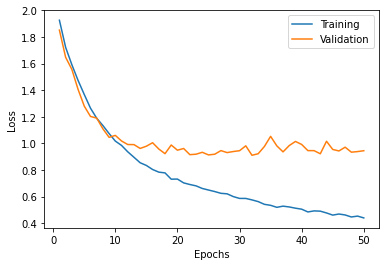

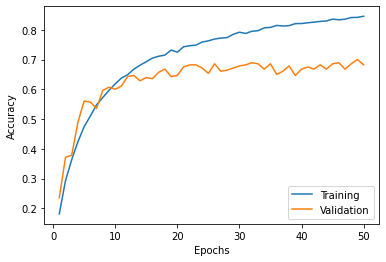

In [ ]:
plot_history(history)

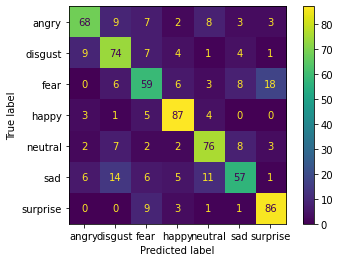

Score on test set: 72.43%


In [ ]:
# Codice per fare la matrice di confusione

classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

predictions = tuned_model.predict(test_images)
predictions = [numpy.argmax(predictions[i]) for i in range(len(predictions))]

test_labels_for_confusion_matrix = [numpy.argmax(test_labels[i]) for i in range(len(test_labels))]

confusionMatrix = confusion_matrix(y_true = test_labels_for_confusion_matrix, y_pred = predictions)
ConfusionMatrixDisplay(confusion_matrix = confusionMatrix, display_labels = classes).plot()
matplotlib.pyplot.show()

# Per far vedere che è uguale a quello calcolato nel prossimo blocco di codice
test_score = numpy.mean(numpy.diagonal(confusionMatrix / numpy.sum(confusionMatrix, axis = 1)))
print('%s: %.2f%%' % ('Score on test set', test_score * 100))

In [ ]:
test_score = tuned_model.evaluate(test_images, test_labels, verbose = 0)
print('%s: %.2f%%' % ('Score on test set', test_score[1] * 100))

Score on test set: 72.43%


## 2) Feature Extraction

### Caricamento del dataset

In [ ]:
# Training set
train_path = '/content/gdrive/MyDrive/ProgettoAML/data/new_train/*/*.jpg'
train_files = glob(train_path)

train_images = []
train_labels = []

for path in train_files:
  # Caricamento e preprocessing immagini
  img = image.load_img(path, target_size = (224, 224))
  img = image.img_to_array(img)
  img = preprocess_input(img)
  train_images.append(img)
  
  # Caricamento label
  label = path.split('/')[-2]
  train_labels.append(label)

train_images = numpy.array(train_images)

label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_labels)

train_images, train_labels = shuffle(train_images, train_labels, random_state = 42)

print('train_images.shape:', train_images.shape)
print('train_labels.shape:', train_labels.shape)
print('--------------------------------------------------')

# Validation set
train_images, validation_images, train_labels, validation_labels = train_test_split(train_images, train_labels, test_size = 0.1, random_state = 42)

print('train_images.shape:', train_images.shape)
print('train_labels.shape:', train_labels.shape)

print('validation_images.shape:', validation_images.shape)
print('validation_labels.shape:', validation_labels.shape)
print('--------------------------------------------------')

# Test set
test_path = '/content/gdrive/MyDrive/ProgettoAML/data/new_test/*/*.jpg'
test_files = glob(test_path)

test_images = []
test_labels = []

for path in test_files:
  # Caricamento e preprocessing immagini
  img = image.load_img(path, target_size = (224, 224))
  img = image.img_to_array(img)
  img = preprocess_input(img)
  test_images.append(img)
  
  # Caricamento label
  label = path.split('/')[-2]
  test_labels.append(label)

test_images = numpy.array(test_images)

label_encoder = LabelEncoder()
test_labels = label_encoder.fit_transform(test_labels)

print('test_images.shape:', test_images.shape)
print('test_labels.shape:', test_labels.shape)

train_images.shape: (2800, 224, 224, 3)
train_labels.shape: (2800,)
--------------------------------------------------
train_images.shape: (2520, 224, 224, 3)
train_labels.shape: (2520,)
validation_images.shape: (280, 224, 224, 3)
validation_labels.shape: (280,)
--------------------------------------------------
test_images.shape: (700, 224, 224, 3)
test_labels.shape: (700,)


### Modello base

In [ ]:
# VGG16 pre-allenata su ImageNet
base_model = VGG16(weights = 'imagenet')
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

### Modello tagliato

In [ ]:
# Taglio al layer block5_pool (che è il taglio migliore)
cut_model = Model(inputs = base_model.input, outputs = base_model.get_layer('block5_pool').output)
cut_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

### Estrazione delle feature

In [ ]:
train_features = cut_model.predict(train_images)
validation_features = cut_model.predict(validation_images)
test_features = cut_model.predict(test_images)

print('train_features.shape:', train_features.shape)
print('validation_features.shape:', validation_features.shape)
print('test_features.shape:', test_features.shape)

train_features.shape: (2520, 7, 7, 512)
validation_features.shape: (280, 7, 7, 512)
test_features.shape: (700, 7, 7, 512)


### Reshape delle feature

In [ ]:
train_features = train_features.reshape(train_features.shape[0], 25088) # 25088 = 7 x 7 x 512
validation_features = validation_features.reshape(validation_features.shape[0], 25088) # 25088 = 7 x 7 x 512
test_features = test_features.reshape(test_features.shape[0], 25088) # 25088 = 7 x 7 x 512

print('train_features.shape:', train_features.shape)
print('validation_features.shape:', validation_features.shape)
print('test_features.shape:', test_features.shape)

train_features.shape: (2520, 25088)
validation_features.shape: (280, 25088)
test_features.shape: (700, 25088)


### Random Forest Classifier

In [ ]:
randomForestClassifier = RandomForestClassifier(n_estimators = 2000, max_features = 'sqrt', random_state = 42)
randomForestClassifier.fit(train_features, train_labels)

RandomForestClassifier(max_features='sqrt', n_estimators=2000, random_state=42)

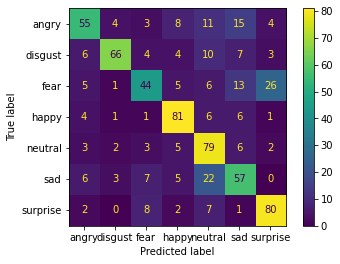

Score on test set: 66.00%


In [ ]:
# Codice per fare la matrice di confusione

classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

predictions = randomForestClassifier.predict(test_features)

confusionMatrix = confusion_matrix(y_true = test_labels, y_pred = predictions)
ConfusionMatrixDisplay(confusion_matrix = confusionMatrix, display_labels = classes).plot()
matplotlib.pyplot.show()

# Per far vedere che è uguale a quello calcolato nel prossimo blocco di codice
test_score = numpy.mean(numpy.diagonal(confusionMatrix / numpy.sum(confusionMatrix, axis = 1)))
print('%s: %.2f%%' % ('Score on test set', test_score * 100))

In [ ]:
test_score = randomForestClassifier.score(test_features, test_labels)
print('%s: %.2f%%' % ('Score on test set', test_score * 100))

Score on test set: 66.00%


### Support Vector Machine Classifier

In [ ]:
supportVectorMachineClassifier = svm.SVC(kernel = 'linear', random_state = 42)
supportVectorMachineClassifier.fit(train_features, train_labels)

SVC(kernel='linear', random_state=42)

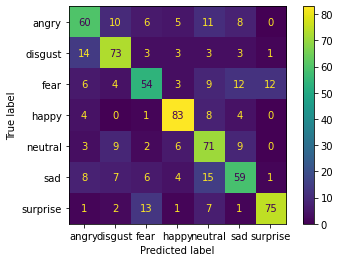

Score on test set: 67.86%


In [ ]:
# Codice per fare la matrice di confusione

classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

predictions = supportVectorMachineClassifier.predict(test_features)

confusionMatrix = confusion_matrix(y_true = test_labels, y_pred = predictions)
ConfusionMatrixDisplay(confusion_matrix = confusionMatrix, display_labels = classes).plot()
matplotlib.pyplot.show()

# Per far vedere che è uguale a quello calcolato nel prossimo blocco di codice
test_score = numpy.mean(numpy.diagonal(confusionMatrix / numpy.sum(confusionMatrix, axis = 1)))
print('%s: %.2f%%' % ('Score on test set', test_score * 100))

In [ ]:
test_score = supportVectorMachineClassifier.score(test_features, test_labels)
print('%s: %.2f%%' % ('Score on test set', test_score * 100))

Score on test set: 67.86%
